# Timescale Distribution Sweep Analysis

Analyze grid cell properties across different neural timescale distributions:
- **Discrete (1 value)**: Single timescale (α=0.5)
- **Discrete (2 values)**: Two timescales (α=0.25, 0.75)
- **Discrete (4 values)**: Four timescales (α=0.2, 0.4, 0.6, 0.8)
- **Power-law**: Continuous 1/f² distribution

Each distribution tested with both **ReLU** and **Tanh** activations (8 experiments total).

For each network we analyze:
1. Grid score distribution
2. Spatial frequency distribution (for grid cells)
3. Top 9 grid cell rate maps


In [21]:
# === IMPORTS AND CONFIGURATION ===
import os
import yaml
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Add parent directory to path for imports
import sys
sys.path.insert(0, str(Path.cwd().parent))

from timescales.rnns.multitimescale_rnn import MultiTimescaleRNN
from timescales.datamodules.path_integration import PathIntegrationDataModule
from timescales.analysis.spatial import SpatialAnalyzer

# === SWEEP CONFIGURATION ===
# Update this path after running the sweep
SWEEP_DIR = Path("/home/facosta/timescales/timescales/logs/experiments/timescale_distribution_sweep_20260122_043728")

# Grid cell threshold
GRID_SCORE_THRESHOLD = 0.0

# Experiment names (must match sweep config)
EXPERIMENT_NAMES = [
    "ReLU_discrete_1",
    "ReLU_discrete_2", 
    "ReLU_discrete_4",
    "ReLU_powerlaw",
    "Tanh_discrete_1",
    "Tanh_discrete_2",
    "Tanh_discrete_4",
    "Tanh_powerlaw",
]

# Spatial analysis parameters
NUM_TRAJECTORIES = 2000  # Increased for better rate map estimation
ARENA_SIZE = 2.2
BIN_SIZE = 0.05
MIN_OCCUPANCY = 10  # Minimum visits to a bin for reliable estimate

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
print(f"Grid score threshold: {GRID_SCORE_THRESHOLD}")
print(f"Sweep directory: {SWEEP_DIR}")

Using device: cuda
Grid score threshold: 0.0
Sweep directory: /home/facosta/timescales/timescales/logs/experiments/timescale_distribution_sweep_20260122_043728


## Helper Functions


In [22]:
def load_model_and_compute_grid_analysis(
    sweep_dir: Path,
    exp_name: str,
    seed: int = 0,
    device: str = "cuda",
    num_trajectories: int = 2000,
    arena_size: float = 2.2,
    bin_size: float = 0.05,
    min_occupancy: int = 10,
) -> dict:
    """
    Load a trained model and compute grid scores + spatial frequencies.
    
    Returns dict with: scores_60, spatial_frequencies, rate_maps, sacs, exp_name
    """
    exp_path = sweep_dir / exp_name / f"seed_{seed}"
    
    # Load config
    config_path = exp_path / f"config_seed{seed}.yaml"
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    
    # Extract timescale config
    ts_config = config.get("timescales_config", {})
    
    # Get activation function
    activation_name = config.get("activation", "ReLU")
    activation_cls = getattr(nn, activation_name)
    
    # Load model
    model_path = exp_path / f"final_model_seed{seed}.pth"
    model = MultiTimescaleRNN(
        input_size=config["input_size"],
        hidden_size=config["hidden_size"],
        output_size=config["num_place_cells"],
        dt=config["dt"],
        timescales_config=ts_config,
        activation=activation_cls,
        learn_timescales=config.get("learn_timescales", False),
        zero_diag_wrec=config.get("zero_diag_wrec", True),
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    # CRITICAL: Load the place cell centers that the model was trained with
    place_cell_centers_path = exp_path / f"place_cell_centers_seed{seed}.pt"
    place_cell_centers = torch.load(place_cell_centers_path, map_location=device)
    
    # Create data module
    datamodule = PathIntegrationDataModule(
        trajectory_type=config.get("trajectory_type", "ornstein_uhlenbeck"),
        velocity_representation=config.get("velocity_representation", "polar"),
        dt=config["dt"],
        num_time_steps=config["num_time_steps"],
        arena_size=config["arena_size"],
        num_place_cells=config["num_place_cells"],
        place_cell_rf=config["place_cell_rf"],
        DoG=config.get("DoG", True),
        surround_scale=config.get("surround_scale", 2),
        place_cell_layout=config.get("place_cell_layout", "random"),
        behavioral_timescale_mean=config["behavioral_timescale_mean"],
        behavioral_timescale_std=config["behavioral_timescale_std"],
        linear_speed_tau=config.get("linear_speed_tau", 1.0),
        angular_speed_mean=config.get("angular_speed_mean", 0.0),
        angular_speed_std=config.get("angular_speed_std", 1.0),
        angular_speed_tau=config.get("angular_speed_tau", 0.4),
        num_trajectories=num_trajectories,
        batch_size=64,
        num_workers=10,
        train_val_split=0.0,  # All data goes to val for evaluation
    )
    
    # CRITICAL: Override with the trained place cell centers BEFORE setup()
    datamodule.place_cell_centers = place_cell_centers
    datamodule.setup()
    
    # Create spatial analyzer
    spatial = SpatialAnalyzer(model=model, device=device)
    
    # Compute rate maps (use val_dataloader since train_val_split=0.0)
    spatial.compute_rate_maps(
        eval_loader=datamodule.val_dataloader(),
        arena_size=arena_size,
        bin_size=bin_size,
        num_trajectories=num_trajectories,
        min_occupancy=min_occupancy,
    )
    
    # Compute grid scores with spatial frequencies
    results = spatial.compute_grid_scores_with_frequency()
    
    return {
        "scores_60": results["scores_60"],
        "spatial_frequencies": results["spatial_frequencies"],
        "grid_spacings": results["grid_spacings"],
        "rate_maps": spatial.rate_maps,
        "sacs": results["sacs"],
        "exp_name": exp_name,
        "bin_centers_x": spatial.bin_centers_x,
        "bin_centers_y": spatial.bin_centers_y,
    }


In [23]:
def plot_grid_score_histogram(
    scores: np.ndarray,
    threshold: float,
    ax: plt.Axes,
    title: str = "",
) -> None:
    """Plot grid score histogram with threshold line."""
    ax.hist(scores, bins=30, color="steelblue", edgecolor="black", alpha=0.7)
    ax.axvline(x=threshold, color="red", linestyle="--", linewidth=2, label=f"threshold={threshold}")
    
    n_grid_cells = np.sum(scores > threshold)
    n_total = len(scores)
    pct = 100 * n_grid_cells / n_total
    
    ax.set_xlabel("Grid Score (60°)")
    ax.set_ylabel("Count")
    ax.set_title(f"{title}\n{n_grid_cells}/{n_total} grid cells ({pct:.1f}%)")
    ax.legend(loc="upper right", fontsize=8)


def plot_spatial_frequency_histogram(
    freqs: np.ndarray,
    scores: np.ndarray,
    threshold: float,
    ax: plt.Axes,
    title: str = "Spatial Frequency",
) -> None:
    """Plot spatial frequency histogram for grid cells only."""
    grid_cell_mask = scores > threshold
    grid_cell_freqs = freqs[grid_cell_mask]
    valid_freqs = grid_cell_freqs[~np.isnan(grid_cell_freqs)]
    
    if len(valid_freqs) > 0:
        ax.hist(valid_freqs, bins=20, color="darkorange", edgecolor="black", alpha=0.7)
        mean_freq = np.mean(valid_freqs)
        ax.axvline(x=mean_freq, color="darkred", linestyle="--", linewidth=2, label=f"mean={mean_freq:.2f}")
        ax.set_title(f"{title} (n={len(valid_freqs)})")
        ax.legend(loc="upper right", fontsize=8)
    else:
        ax.text(0.5, 0.5, "No grid cells", ha="center", va="center",
                transform=ax.transAxes, fontsize=12, color="gray")
        ax.set_title(f"{title} (n=0)")
    
    ax.set_xlabel("Spatial Frequency (cycles/m)")
    ax.set_ylabel("Count")


def plot_top_rate_maps(
    result: dict,
    threshold: float,
    num_cells: int = 9,
    figsize: tuple = (12, 12),
) -> plt.Figure:
    """Plot rate maps for top grid cells in a 3x3 grid."""
    scores = result["scores_60"]
    rate_maps = result["rate_maps"]
    bin_centers_x = result["bin_centers_x"]
    bin_centers_y = result["bin_centers_y"]
    exp_name = result["exp_name"]
    
    # Get indices of top grid cells
    sorted_indices = np.argsort(scores)[::-1]
    top_indices = sorted_indices[:num_cells]
    
    # Check how many are actually above threshold
    n_above_threshold = np.sum(scores[top_indices] > threshold)
    
    cols = 3
    rows = (num_cells + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    
    for i, unit_idx in enumerate(top_indices):
        ax = axes[i]
        rate_map = rate_maps[unit_idx].T  # Transpose for correct orientation
        
        # Mask NaN values
        rate_map_masked = np.ma.masked_where(np.isnan(rate_map), rate_map)
        
        im = ax.imshow(
            rate_map_masked,
            extent=[bin_centers_x[0], bin_centers_x[-1], bin_centers_y[0], bin_centers_y[-1]],
            origin="lower",
            cmap="viridis",
            aspect="equal",
        )
        
        score = scores[unit_idx]
        is_grid = "✓" if score > threshold else ""
        ax.set_title(f"Unit {unit_idx} | Score={score:.3f} {is_grid}", fontsize=10)
        ax.set_xlabel("X (m)")
        ax.set_ylabel("Y (m)")
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    # Hide unused axes
    for i in range(num_cells, len(axes)):
        axes[i].set_visible(False)
    
    fig.suptitle(f"{exp_name}: Top {num_cells} Units by Grid Score\n({n_above_threshold} above threshold)", 
                 fontsize=14, fontweight="bold")
    plt.tight_layout()
    return fig


## Load All Experiments


In [24]:
# Load all experiments
all_results = {}

for exp_name in EXPERIMENT_NAMES:
    print(f"\n{'='*60}")
    print(f"Loading: {exp_name}")
    print('='*60)
    
    try:
        result = load_model_and_compute_grid_analysis(
            sweep_dir=SWEEP_DIR,
            exp_name=exp_name,
            device=device,
            num_trajectories=NUM_TRAJECTORIES,
            arena_size=ARENA_SIZE,
            bin_size=BIN_SIZE,
        )
        all_results[exp_name] = result
        
        # Quick summary
        n_grid = np.sum(result["scores_60"] > GRID_SCORE_THRESHOLD)
        print(f"  -> {n_grid} grid cells (threshold={GRID_SCORE_THRESHOLD})")
        
    except FileNotFoundError as e:
        print(f"  -> SKIPPED: {e}")

print(f"\n{'='*60}")
print(f"Loaded {len(all_results)}/{len(EXPERIMENT_NAMES)} experiments")
print('='*60)


Loading: ReLU_discrete_1
Behavioral timescale parameterization:
  τ_behavior: mean=0.600s, std=0.000s
  → linear_speed: mean=0.333m/s, std=0.000m/s
Computing concurrent spatial rate maps using 2000 trajectories...
Spatial grid: 44 x 44 bins of size 0.05
Hidden units to analyze: 256
Processed 64/2000 trajectories...
Data collection complete. Total trajectories: 2000
Rate maps created. Bins with sufficient data: 484/1936
Computing grid scores for 256 units...
  Processed 50/256 units...
  Processed 100/256 units...
  Processed 150/256 units...
  Processed 200/256 units...
  Processed 250/256 units...
Grid score computation complete!
  Mean 60° score: -0.081 ± 0.058
  Mean 90° score: 0.420 ± 0.195
  Max 60° score: 0.195
  Max 90° score: 1.005
Computing spatial frequencies for 256 units...
  Processed 50/256 units...
  Processed 100/256 units...
  Processed 150/256 units...
  Processed 200/256 units...
  Processed 250/256 units...
Spatial frequency computation complete!
  Mean frequency: 

## Summary: Grid Score & Spatial Frequency Distributions

Side-by-side comparison of all 8 experiments.


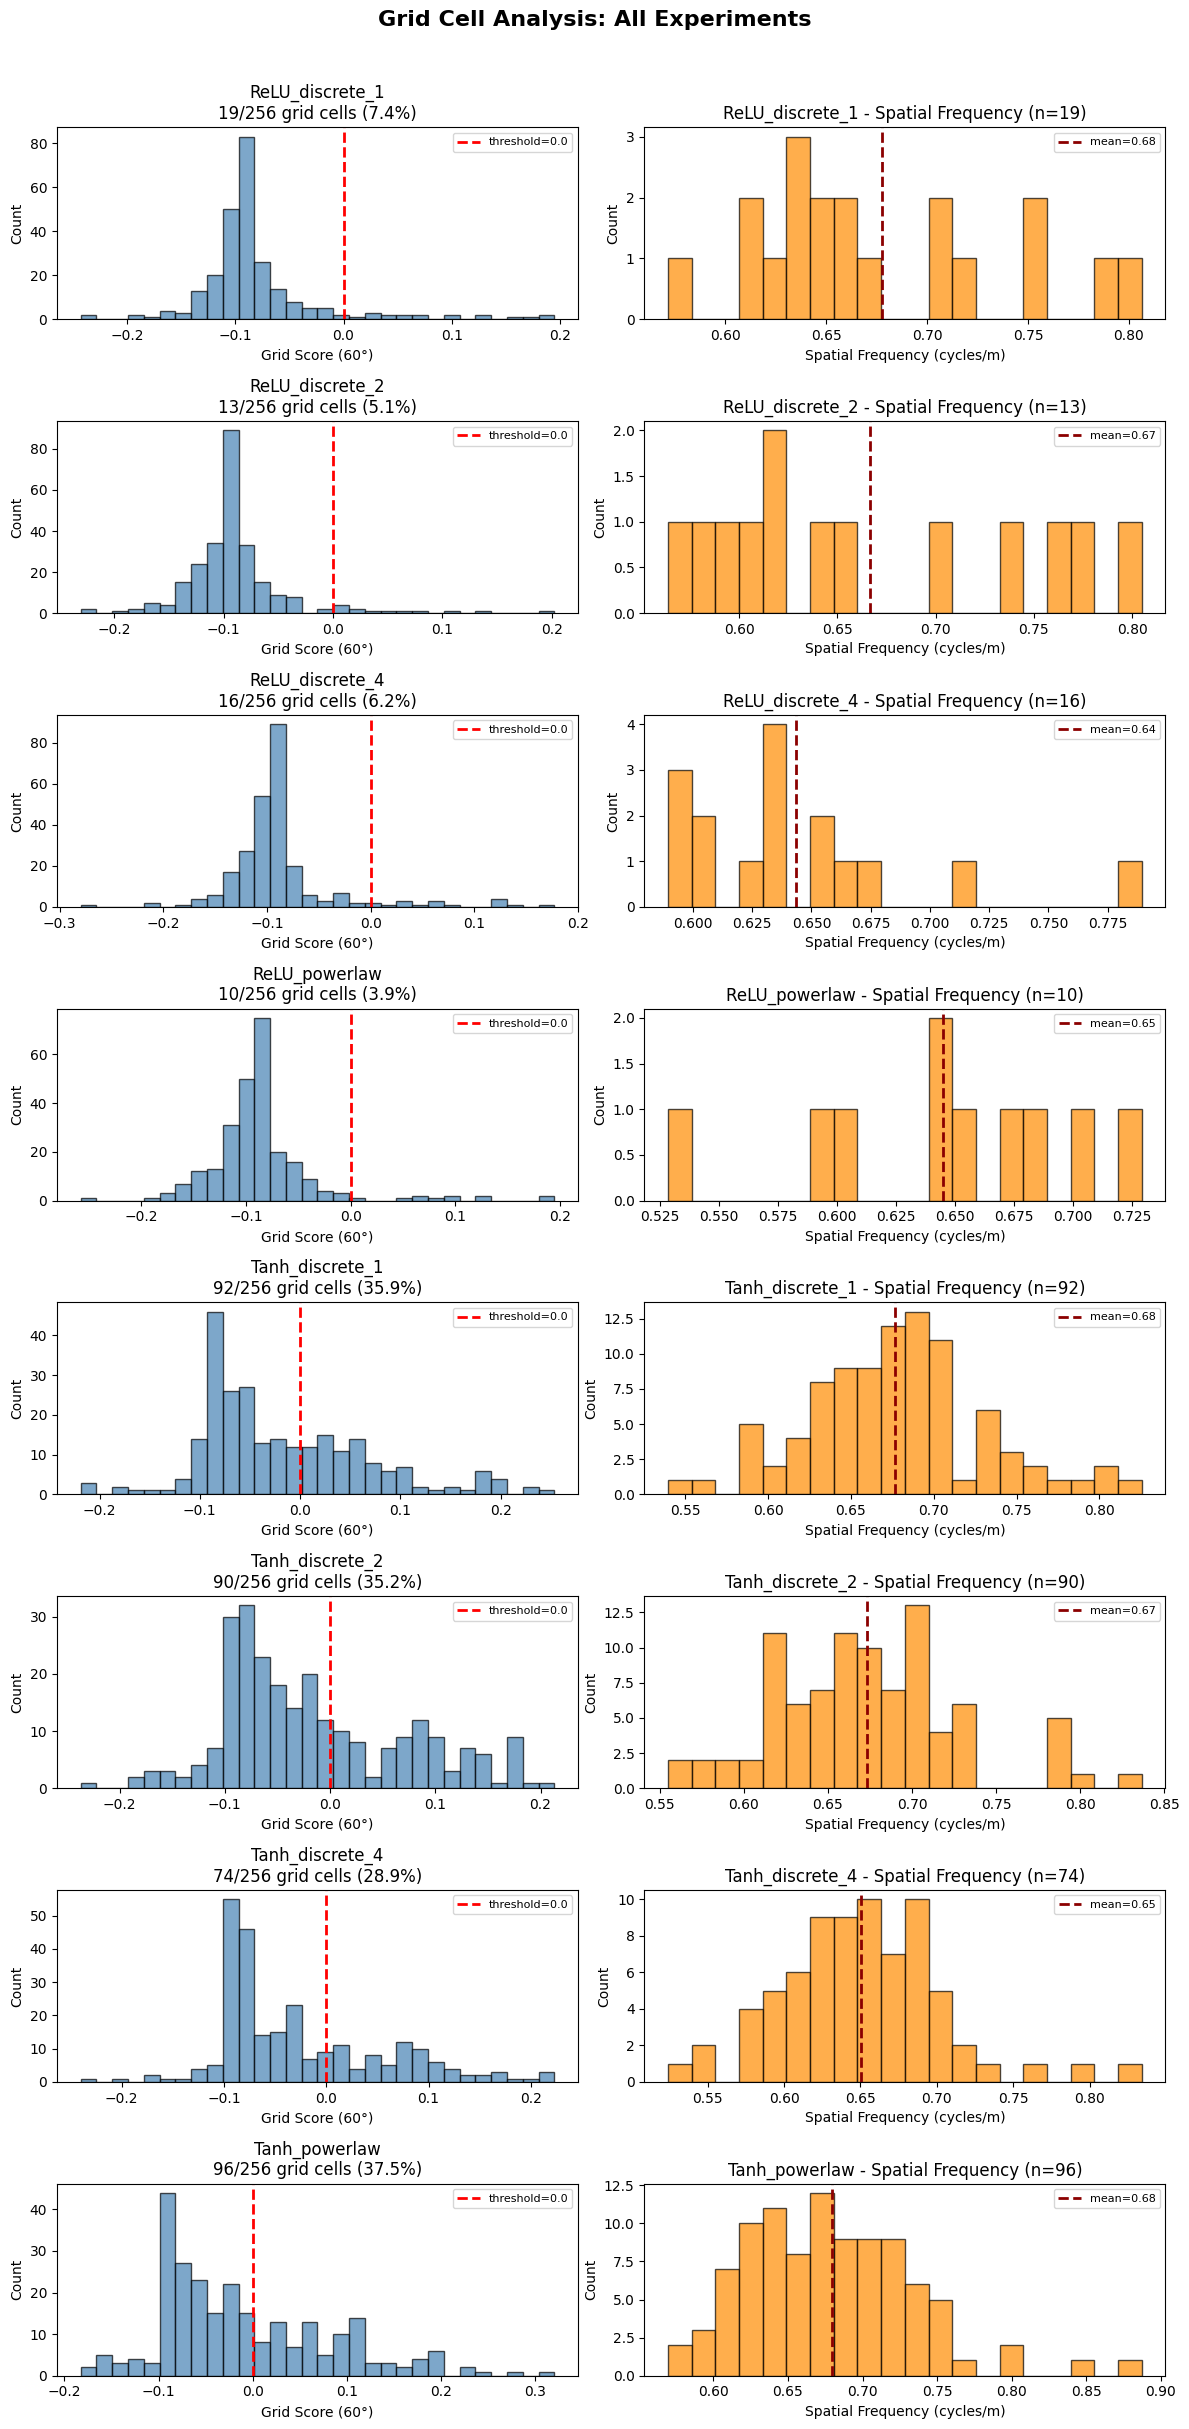

In [25]:
# Summary plot: Grid scores and spatial frequencies for all experiments
n_experiments = len(all_results)
if n_experiments > 0:
    fig, axes = plt.subplots(n_experiments, 2, figsize=(12, 3 * n_experiments))
    
    for row_idx, (exp_name, result) in enumerate(all_results.items()):
        # Grid score histogram
        plot_grid_score_histogram(
            scores=result["scores_60"],
            threshold=GRID_SCORE_THRESHOLD,
            ax=axes[row_idx, 0],
            title=exp_name,
        )
        
        # Spatial frequency histogram
        plot_spatial_frequency_histogram(
            freqs=result["spatial_frequencies"],
            scores=result["scores_60"],
            threshold=GRID_SCORE_THRESHOLD,
            ax=axes[row_idx, 1],
            title=f"{exp_name} - Spatial Frequency",
        )
    
    fig.suptitle("Grid Cell Analysis: All Experiments", fontsize=16, fontweight="bold", y=1.01)
    plt.tight_layout()
    plt.savefig(SWEEP_DIR / "summary_grid_scores_and_frequencies.png", dpi=150, bbox_inches="tight")
    plt.show()
else:
    print("No experiments loaded - check SWEEP_DIR path")


## Top Grid Cell Rate Maps

For each experiment, show the rate maps of the top 9 units by grid score.



ReLU_discrete_1


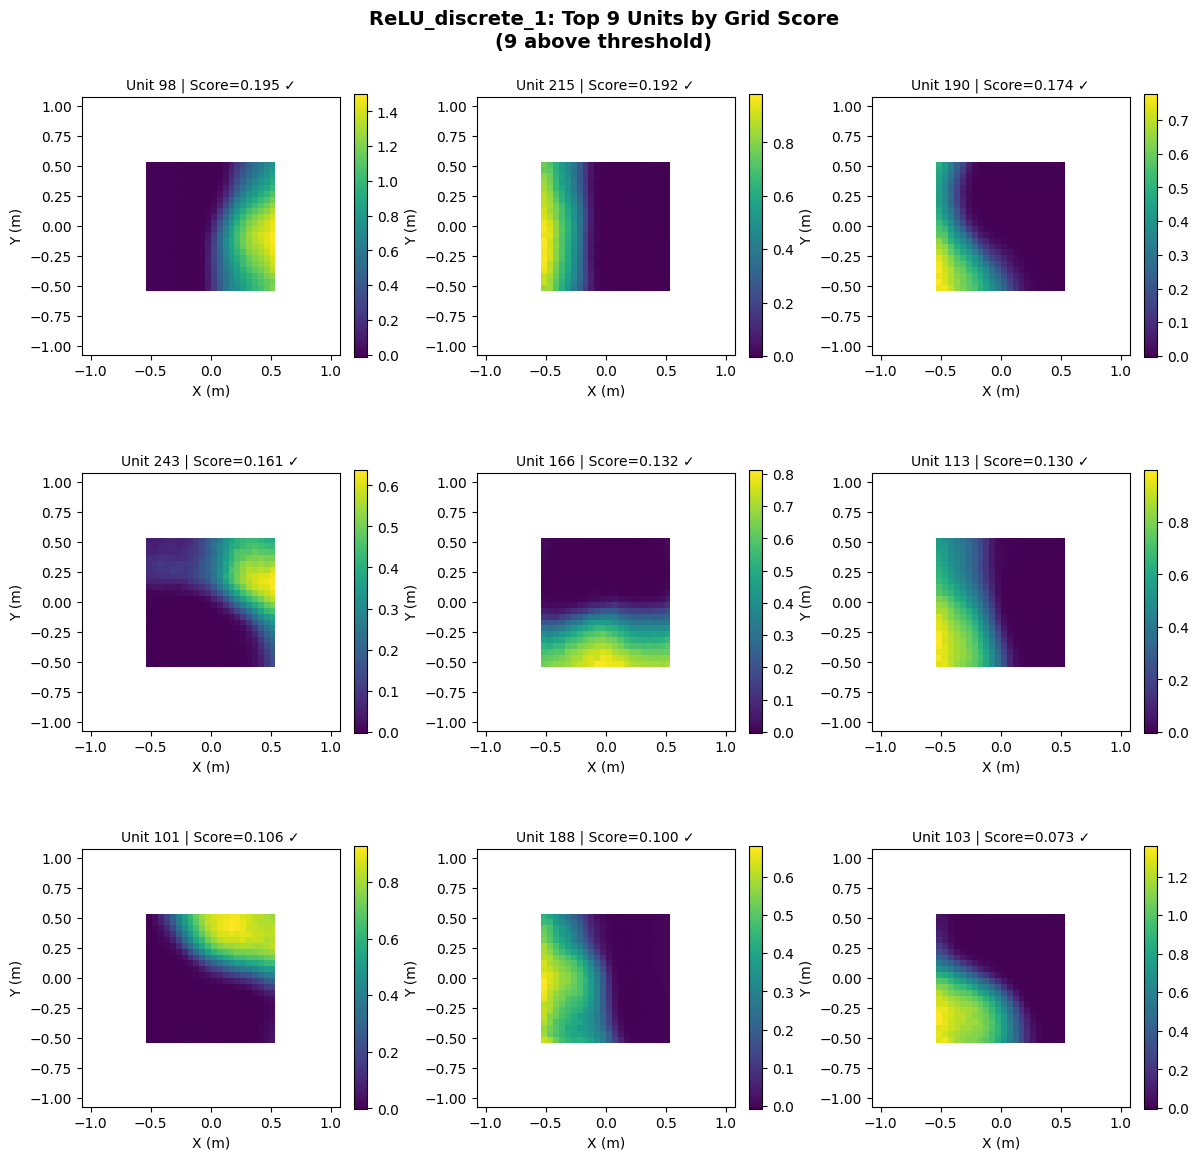


ReLU_discrete_2


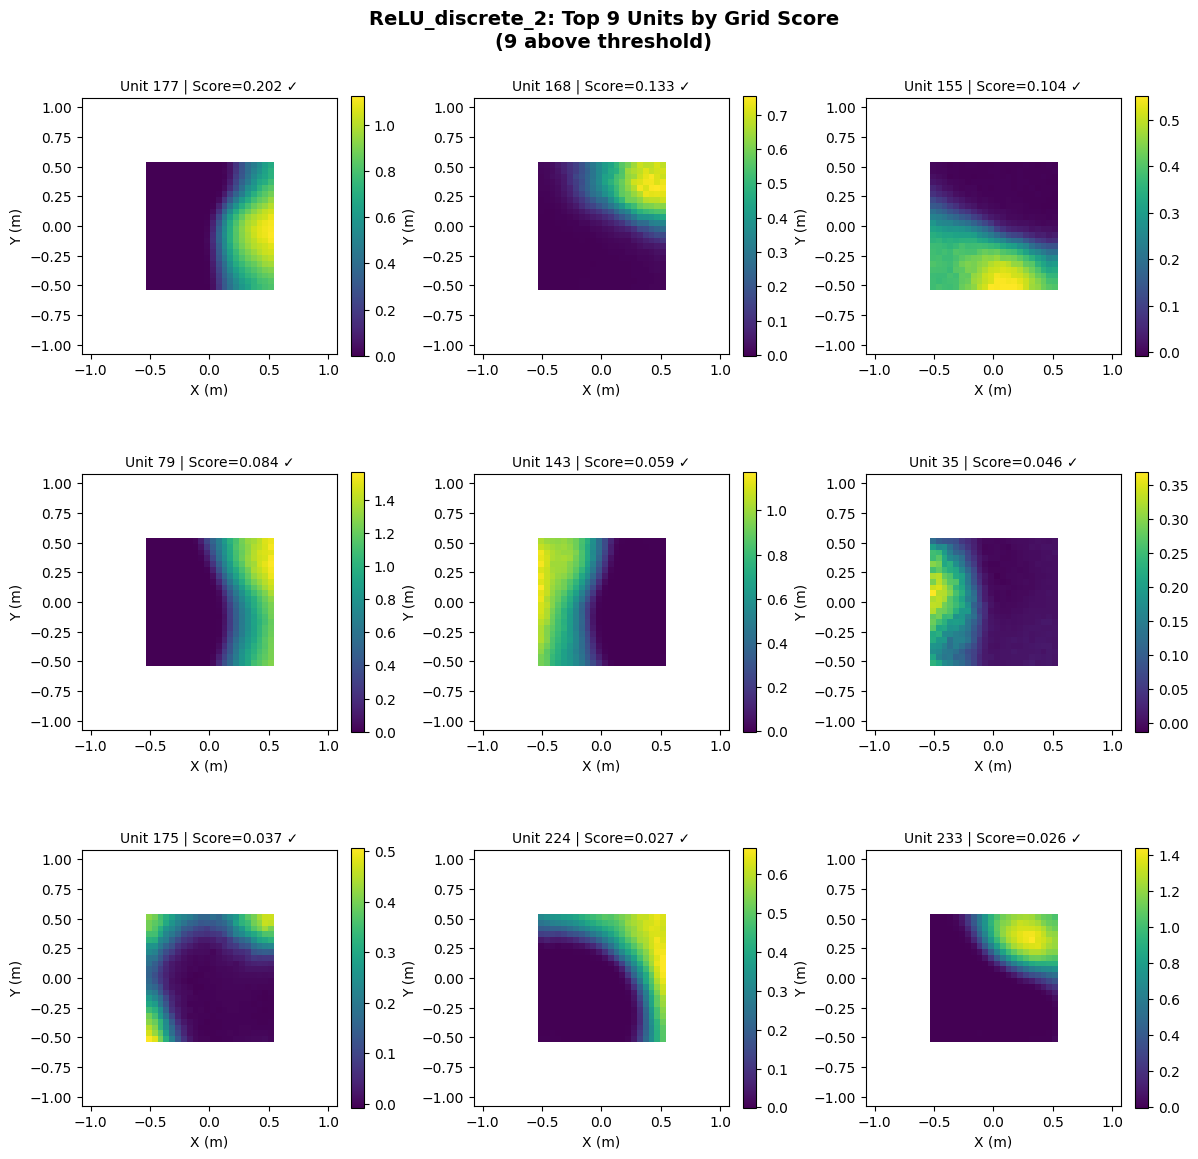


ReLU_discrete_4


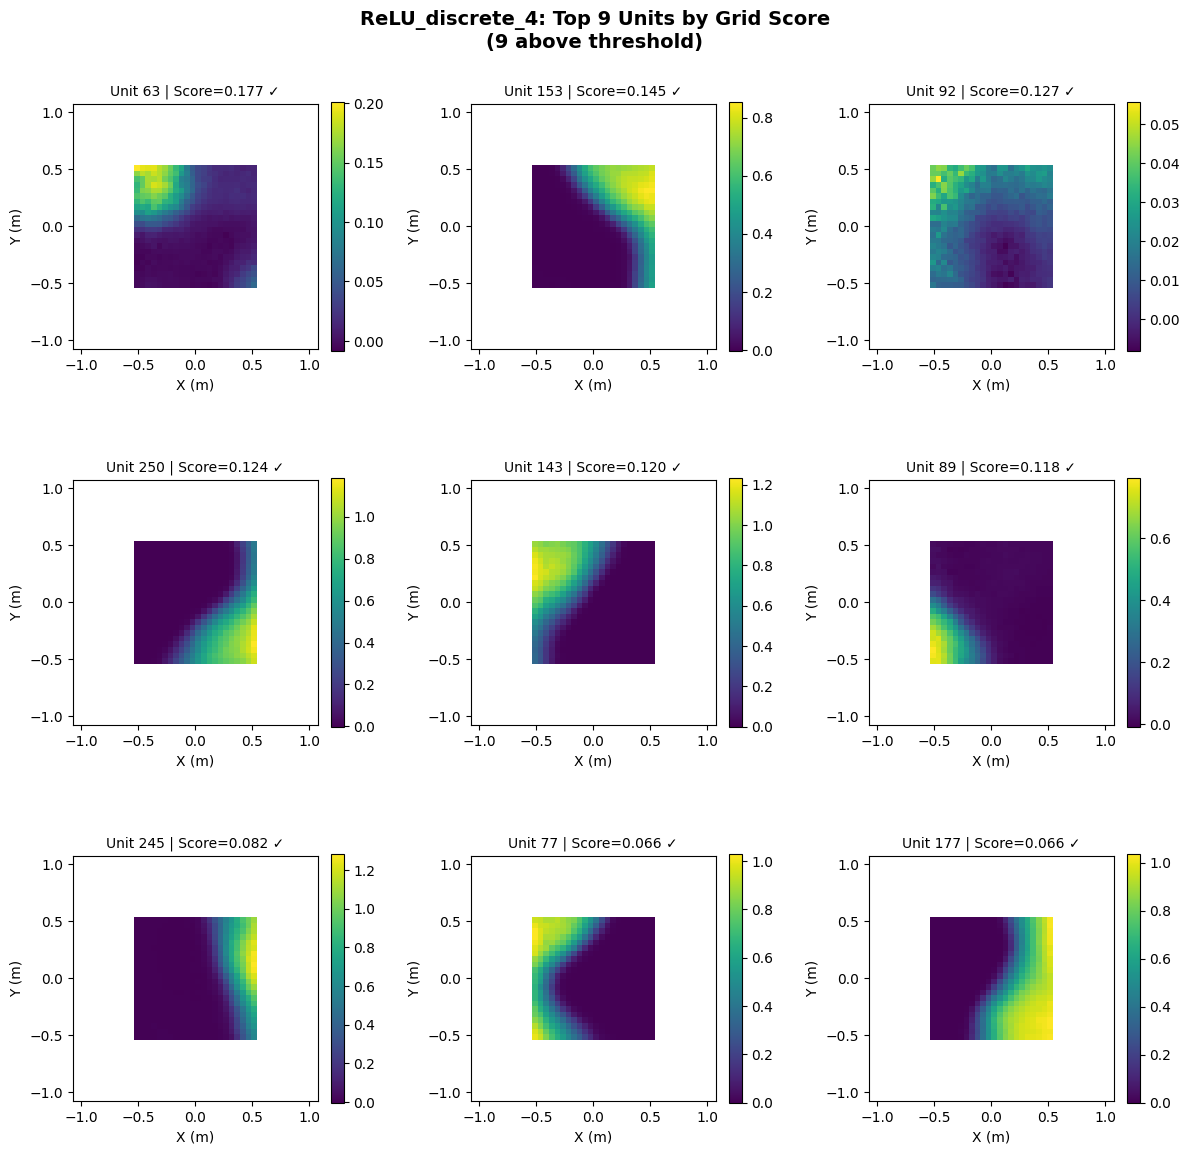


ReLU_powerlaw


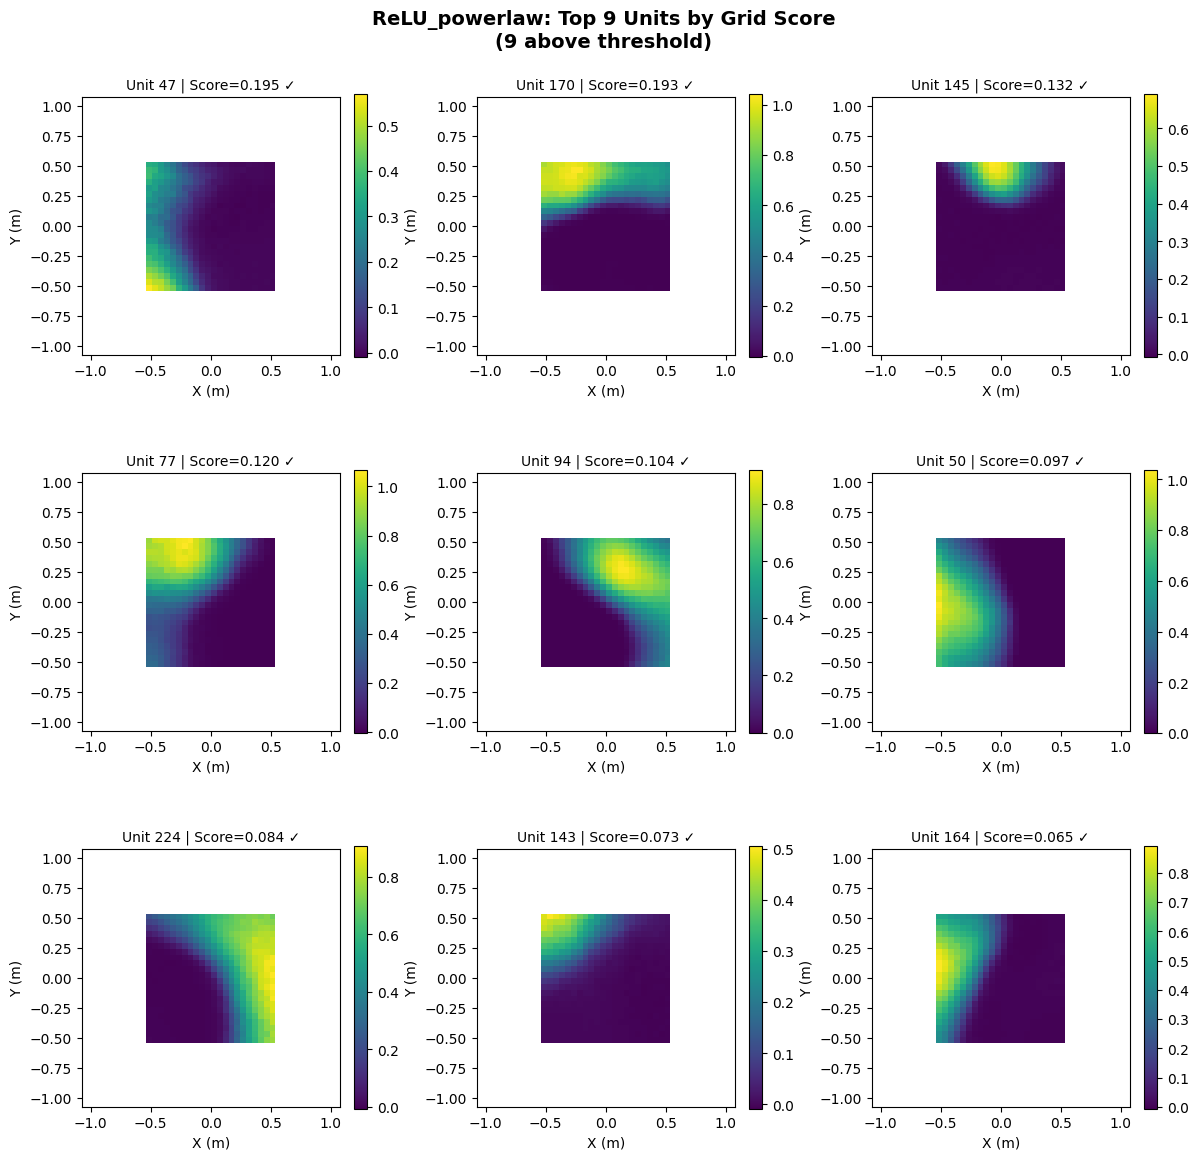


Tanh_discrete_1


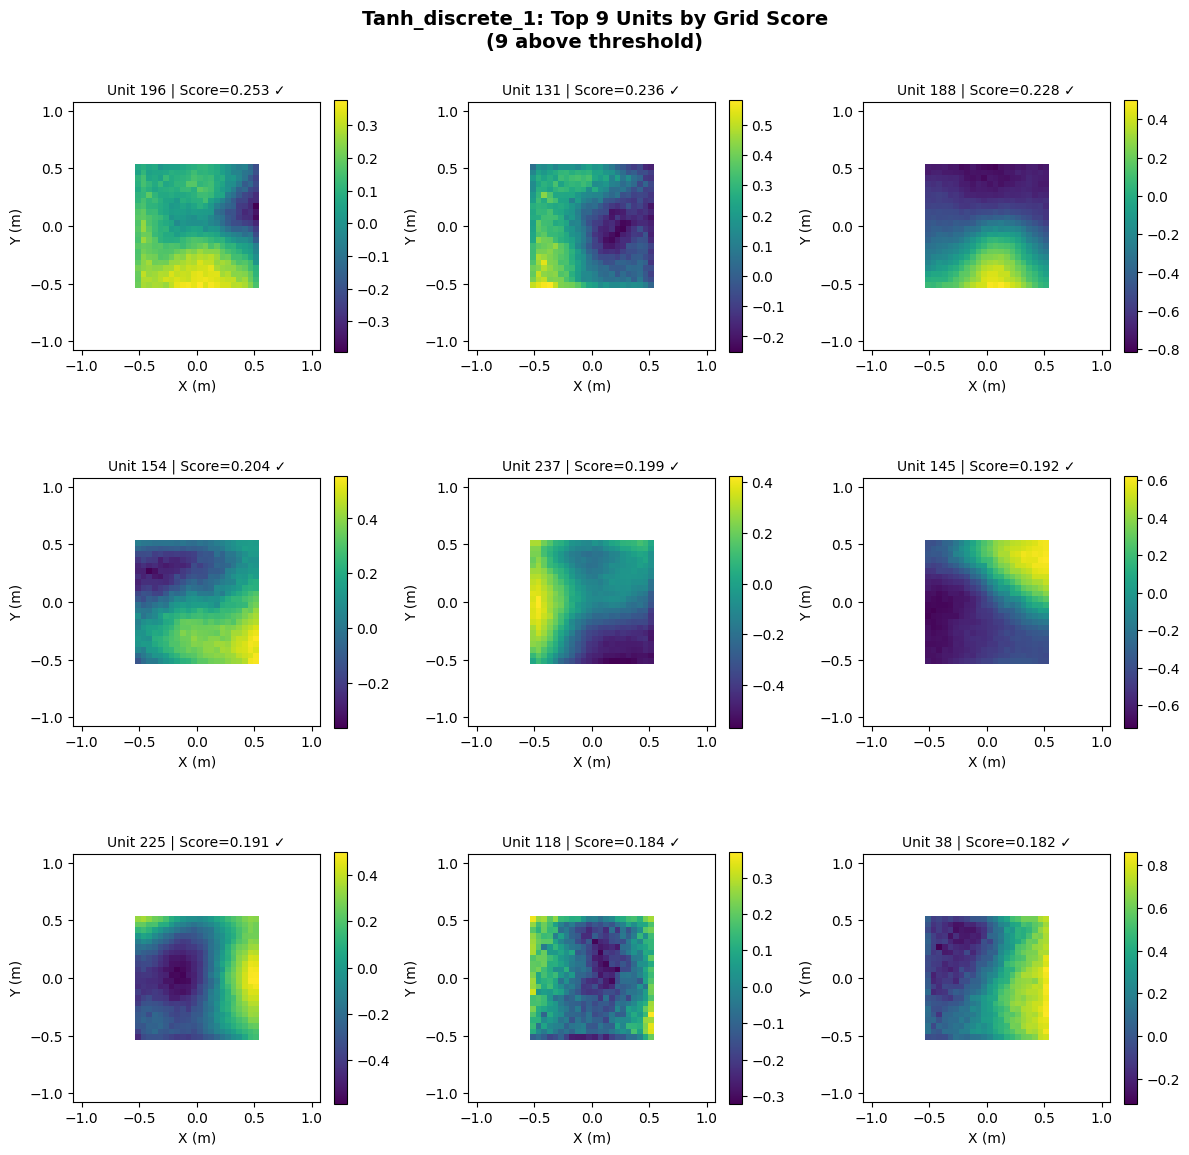


Tanh_discrete_2


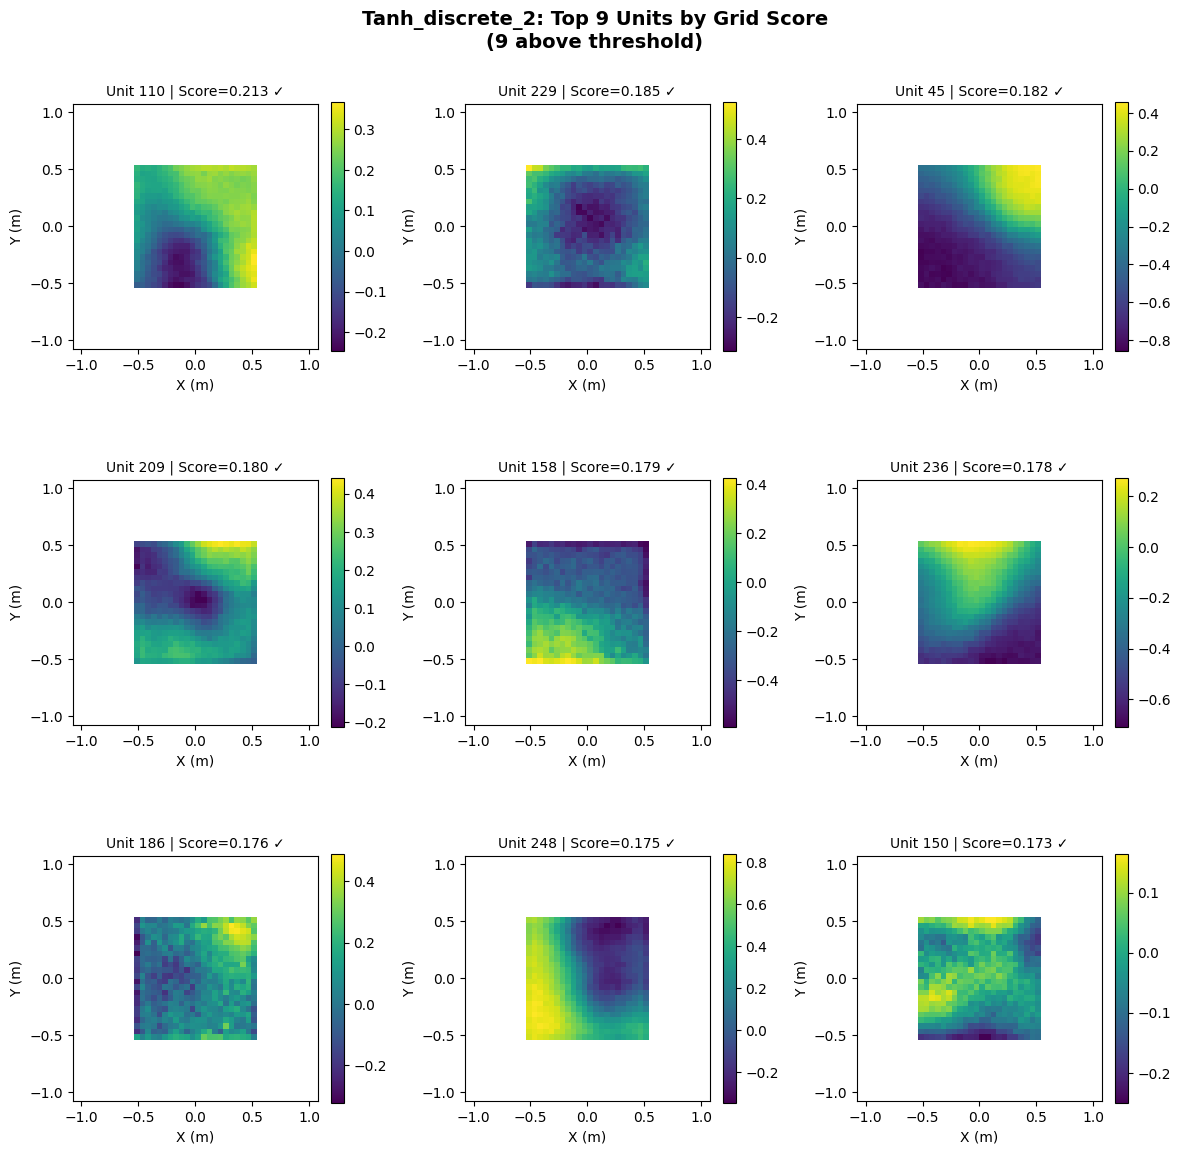


Tanh_discrete_4


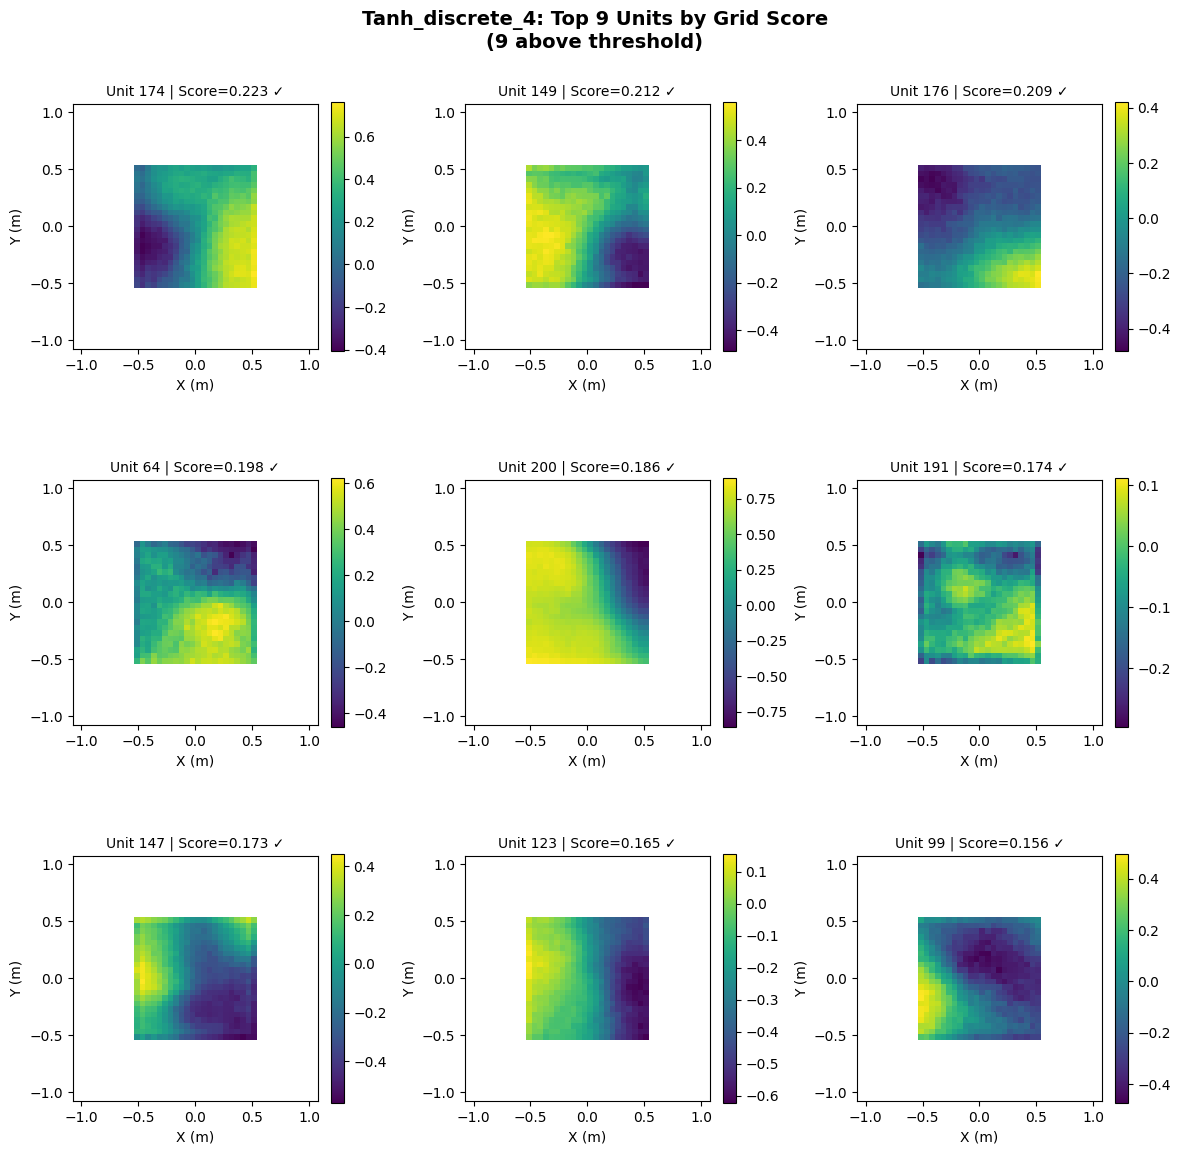


Tanh_powerlaw


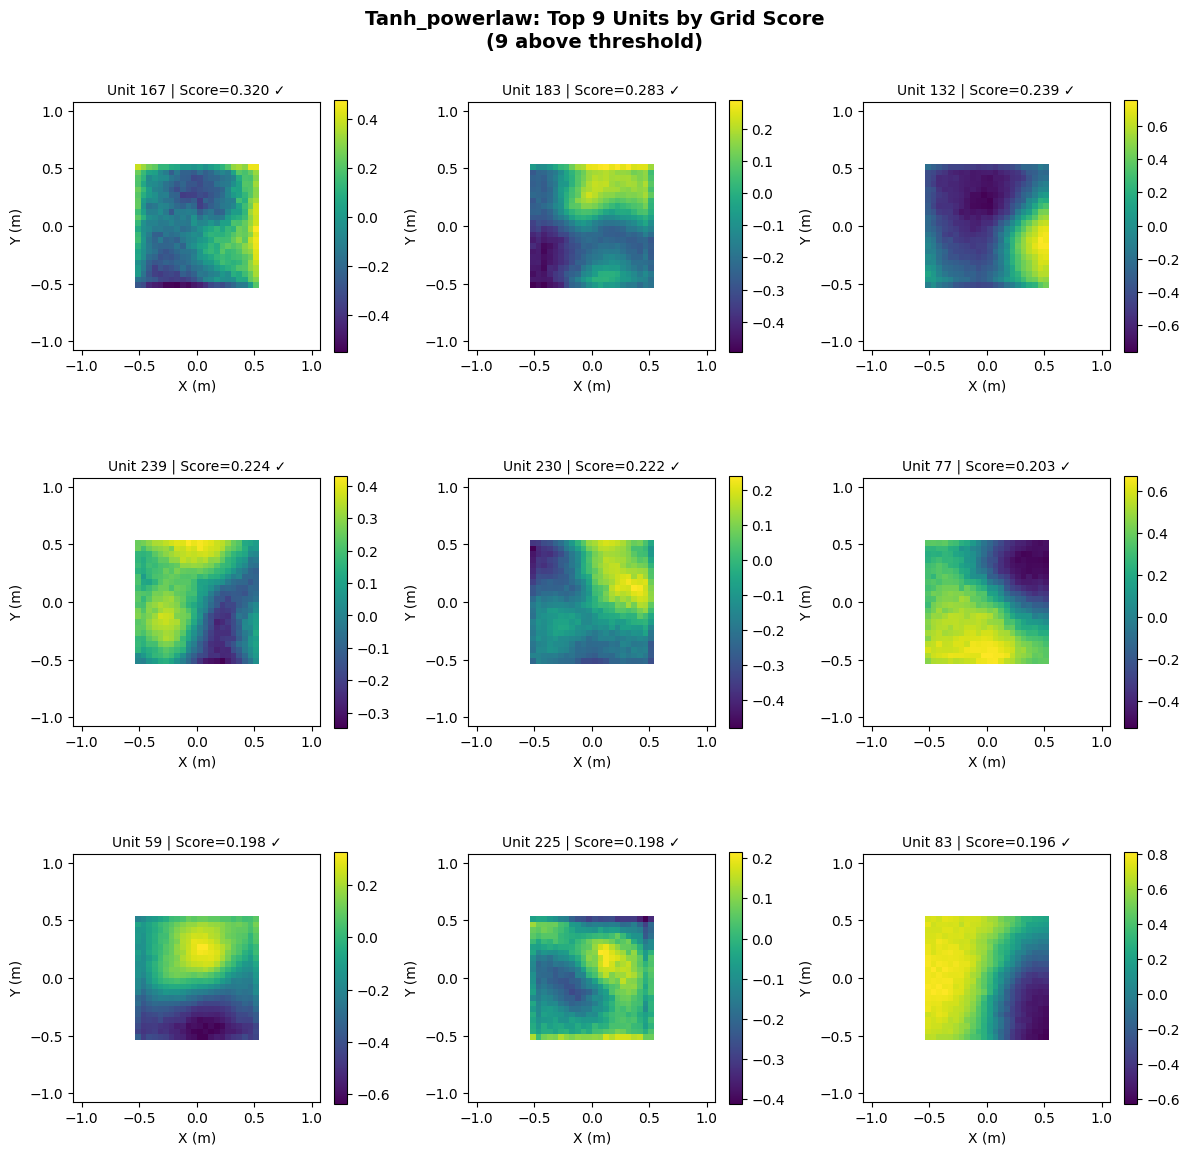

In [26]:
# Plot top rate maps for each experiment
for exp_name, result in all_results.items():
    print(f"\n{'='*60}")
    print(f"{exp_name}")
    print('='*60)
    
    fig = plot_top_rate_maps(
        result=result,
        threshold=GRID_SCORE_THRESHOLD,
        num_cells=9,
        figsize=(12, 12),
    )
    
    # Save figure
    fig.savefig(SWEEP_DIR / f"{exp_name}_top_rate_maps.png", dpi=150, bbox_inches="tight")
    plt.show()


## Summary Statistics


In [27]:
# Summary table
print("=" * 80)
print("SUMMARY: Grid Cell Statistics by Experiment")
print("=" * 80)
print(f"{'Experiment':<25} {'# Grid Cells':>12} {'% Grid':>10} {'Mean Freq':>12} {'Mean Spacing':>14}")
print("-" * 80)

for exp_name, result in all_results.items():
    scores = result["scores_60"]
    freqs = result["spatial_frequencies"]
    spacings = result["grid_spacings"]
    
    n_grid = np.sum(scores > GRID_SCORE_THRESHOLD)
    pct_grid = 100 * n_grid / len(scores)
    
    # Stats for grid cells only
    mask = scores > GRID_SCORE_THRESHOLD
    if np.sum(mask) > 0:
        grid_freqs = freqs[mask]
        grid_spacings = spacings[mask]
        valid_freqs = grid_freqs[~np.isnan(grid_freqs)]
        valid_spacings = grid_spacings[~np.isnan(grid_spacings)]
        
        mean_freq = np.mean(valid_freqs) if len(valid_freqs) > 0 else np.nan
        mean_spacing = np.mean(valid_spacings) if len(valid_spacings) > 0 else np.nan
    else:
        mean_freq = np.nan
        mean_spacing = np.nan
    
    freq_str = f"{mean_freq:.3f}" if not np.isnan(mean_freq) else "N/A"
    spacing_str = f"{mean_spacing:.3f} m" if not np.isnan(mean_spacing) else "N/A"
    
    print(f"{exp_name:<25} {n_grid:>12} {pct_grid:>9.1f}% {freq_str:>12} {spacing_str:>14}")

print("=" * 80)


SUMMARY: Grid Cell Statistics by Experiment
Experiment                # Grid Cells     % Grid    Mean Freq   Mean Spacing
--------------------------------------------------------------------------------
ReLU_discrete_1                     19       7.4%        0.678        1.488 m
ReLU_discrete_2                     13       5.1%        0.667        1.520 m
ReLU_discrete_4                     16       6.2%        0.644        1.562 m
ReLU_powerlaw                       10       3.9%        0.645        1.563 m
Tanh_discrete_1                     92      35.9%        0.677        1.487 m
Tanh_discrete_2                     90      35.2%        0.673        1.495 m
Tanh_discrete_4                     74      28.9%        0.650        1.548 m
Tanh_powerlaw                       96      37.5%        0.679        1.482 m
